In [1]:
# Load datasets and store in dictionaries
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, classification_report
from sklearn.svm import SVR
from abess import LinearRegression
from abess.decomposition import SparsePCA
from kennard_stone import train_test_split as ks_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
import numpy as np
import os
import synths
import seaborn as sns; sns.set_theme()
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
def get_y_value(path):
    Y_value = pd.read_csv(path, index_col=0)
    Y_value.reset_index(inplace=True, drop=True)
    return Y_value

def get_x_value(path):
    X = pd.read_csv(path, sep='\t', index_col=0, low_memory=False)
    X.reset_index(inplace=True, drop=True)
    X.drop('NAME', axis=1, inplace=True)
    return X

In [3]:
os.chdir('My_Data')
y_values = dict()
for item in os.listdir('.'):
    if '.csv' in item:
        y_values[item[:-4]] = get_y_value(item)
os.chdir('..')
os.getcwd()

'C:\\Users\\clarkep\\PycharmProjects\\Cheminformatics\\InternshipM2_BIU\\WorkingEnvironment\\Phase2'

In [4]:
os.chdir('My_Data')
x_values = dict()
for item in os.listdir('.'):
    if '.txt' in item:
        x_values[item[5:-4]] = get_x_value(item)
os.chdir('..')
os.getcwd()

'C:\\Users\\clarkep\\PycharmProjects\\Cheminformatics\\InternshipM2_BIU\\WorkingEnvironment\\Phase2'

,MW,AMW,Mp,Mi,nTA,nBM,RBF,nDB,nTB,nN,...,s4_numSharedNeighbors,s1_numRotBonds,s2_numRotBonds,s3_numRotBonds,s4_numRotBonds,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s34_phSize,s34_phRelSize
0,907.17,8.807476,0.747356,1.099326,8,44,0.155963,6,4,6,...,0.000000,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000
1,987.28,8.092459,0.717684,1.103600,9,49,0.130769,8,1,4,...,0.000000,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000
2,905.15,7.870870,0.705637,1.106991,9,44,0.131148,8,1,4,...,0.000000,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000
3,823.02,7.620556,0.692030,1.110822,9,39,0.131579,8,1,4,...,0.000000,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000
4,782.04,9.537073,0.738429,1.104670,11,22,0.137931,11,0,3,...,12.666667,0,0.666667,4.333333,9.0,0,0.0,3.666667,10.666667,0.20915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,595.74,8.891642,0.730752,1.103718,6,31,0.140845,2,1,3,...,0.000000,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000
1459,563.74,8.672923,0.739252,1.100466,6,31,0.115942,2,1,3,...,0.000000,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000
1460,665.84,7.481348,0.685335,1.112534,5,34,0.182796,4,1,3,...,0.000000,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000
1461,707.93,7.223776,0.676316,1.114909,7,34,0.176471,4,1,3,...,0.000000,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000


In [5]:
def add_family_to_x(y_dict, x_dict):
    x_dict_plus_fam = dict()
    for dataset in y_dict:
        dataset_plus_fam = pd.concat([x_dict[dataset], y_dict[dataset]['Molecule keywords']], axis=1)
        x_dict_plus_fam[dataset] = dataset_plus_fam
    return x_dict_plus_fam        

def add_active_to_x(y_dict, x_dict):
    dataset_plus_active = pd.concat([x_dict, y_dict['active']], axis=1)
    x_dict_plus_active = dataset_plus_active
    return x_dict_plus_active

In [6]:
X_dict = add_family_to_x(y_values, x_values)

In [9]:
X_dict['HadarDataSet'].head(3)

,MW,AMW,Mp,Mi,nTA,nBM,RBF,nDB,nTB,nN,...,s1_numRotBonds,s2_numRotBonds,s3_numRotBonds,s4_numRotBonds,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s34_phSize,s34_phRelSize,Molecule keywords
0,907.17,8.807476,0.747356,1.099326,8,44,0.155963,6,4,6,...,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,phenothiazine
1,987.28,8.092459,0.717684,1.103600,9,49,0.130769,8,1,4,...,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"coumarin, triphenylamine"
2,905.15,7.870870,0.705637,1.106991,9,44,0.131148,8,1,4,...,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"coumarin, triphenylamine"


In [7]:
def top_families(n_families, y_dict):
    top_families = dict()
    for dataset in y_dict:
        family_list = list(y_dict[dataset].groupby(['Molecule keywords']).count().sort_values('PCE', ascending=False).head(n_families).index)
        top_families[dataset] = family_list
    return top_families

In [10]:
top_compound_families = top_families(6, y_values)

In [11]:
def convert_PCE_to_active(y_dict):
    pce_quartiles = pd.qcut(y_dict['PCE'], q=4, retbins=True)
    y_dict['active'] = np.where(y_dict['PCE']>pce_quartiles[1][3], 1, 0)
    return y_dict

,MW,AMW,Mp,Mi,nTA,nBM,RBF,nDB,nTB,nN,...,s2_numRotBonds,s3_numRotBonds,s4_numRotBonds,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s34_phSize,s34_phRelSize,Molecule keywords,active
0,907.17,8.807476,0.747356,1.099326,8,44,0.155963,6,4,6,...,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000,phenothiazine,0
1,987.28,8.092459,0.717684,1.103600,9,49,0.130769,8,1,4,...,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000,"coumarin, triphenylamine",1
2,905.15,7.870870,0.705637,1.106991,9,44,0.131148,8,1,4,...,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000,"coumarin, triphenylamine",1
3,823.02,7.620556,0.692030,1.110822,9,39,0.131579,8,1,4,...,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000,"coumarin, triphenylamine",0
4,782.04,9.537073,0.738429,1.104670,11,22,0.137931,11,0,3,...,0.666667,4.333333,9.0,0,0.0,3.666667,10.666667,0.20915,coumarin,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,595.74,8.891642,0.730752,1.103718,6,31,0.140845,2,1,3,...,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000,triphenylamine,0
1459,563.74,8.672923,0.739252,1.100466,6,31,0.115942,2,1,3,...,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000,triphenylamine,0
1460,665.84,7.481348,0.685335,1.112534,5,34,0.182796,4,1,3,...,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000,triphenylamine,1
1461,707.93,7.223776,0.676316,1.114909,7,34,0.176471,4,1,3,...,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.00000,triphenylamine,1


,VOC,JSC,FF,PCE,Electrolyte,Active area,Co-adsorbent,Co-sensitizer,Semiconductor,Dye loading,...,Article year.1,Article electronic id,Article keywords,Molecule SMILE,Molecule keywords,Molecule spectrum absorption maxima,Molecule spectrum emission maxima,Molecule spectrum solvent,Dragon Name,active
0,687.0,10.79,0.70,5.19,Iodide_Triiodide,-,-,-,TiO2 (20 nm particle size),-,...,Hong_2012,NaN,NaN,N#C/C(=C\c1ccc(cc1)N(c1ccccc1)CCCCCCN1c2ccccc2...,phenothiazine,439.0,576.0,CH2Cl2/MeOH (1:1),phenothiazine 5.19,0
1,678.0,13.20,0.67,6.00,Iodide_Triiodide,0.158,-,-,TiO2 film (8 uM thick + 5 uM scattering layer),-,...,Alibabaei_2010,NaN,NaN,N#C/C(=C\c1ccc(s1)c1ccc(s1)c1ccc(cc1)N(c1ccc(c...,other,465.0,640.0,dichloromethane,"coumarin, triphenylamine 6.0",1
2,695.0,12.20,0.74,6.20,Iodide_Triiodide,0.158,-,-,TiO2 film (8 uM thick + 5 uM scattering layer),-,...,Alibabaei_2010,NaN,NaN,N#C/C(=C\c1ccc(s1)c1ccc(cc1)N(c1ccc(cc1)/C=C/c...,other,460.0,590.0,dichloromethane,"coumarin, triphenylamine 6.2",1
3,800.0,9.00,0.76,5.50,Iodide_Triiodide,0.158,-,-,TiO2 film (8 uM thick + 5 uM scattering layer),-,...,Alibabaei_2010,NaN,NaN,CCN(c1ccc2c(c1)oc(=O)c(c2)/C=C/c1ccc(cc1)N(c1c...,other,454.0,525.0,dichloromethane,"coumarin, triphenylamine 5.5",0
4,560.0,3.41,0.73,1.39,Iodide_Triiodide,0.16,-,-,TiO2 film,-,...,Han_2014,NaN,NaN,CCN([C@@H]1C=Cc2c(C1)oc(=O)c(c2)c1ccc(cc1)c1cc...,coumarin,465.0,490.0,Acetonitrile-DMSO,coumarin 1.39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,740.0,14.56,0.68,7.39,Iodide_Triiodide,-,-,-,TiO2 film,-,...,Ruangsupapichat_2018,NaN,NaN,C(CCCCC)N1C=2C=CC(=CC2C=2N(C=3C=CC(=CC3C21)/C=...,indoline,411.0,NaN,methanol,indoline 7.39,1
1432,651.0,9.93,0.70,4.52,Iodide_Triiodide,0.12 cm2,-,-,TiO2 film 14 um,296 nmol/cm2,...,Liao_2018,NaN,NaN,C(#N)/C(/C(=O)O)=C\C=1SC(=CC1)C=1C=CC=2N(C3=CC...,phenothiazine,473.0,NaN,CH2Cl2/EtOH,phenothiazine 4.52,0
1433,667.0,12.85,0.71,6.09,Iodide_Triiodide,0.12 cm2,-,-,TiO2 film 14 um,224 nmol/cm2,...,Liao_2018,NaN,NaN,CSC1=CC=C(C=C1)C=1C=C2SC=3C=C(C=CC3N(C2=CC1)CC...,phenothiazine,472.0,NaN,CH2Cl2/EtOH,phenothiazine 6.09,1
1434,659.0,12.46,0.69,5.65,Iodide_Triiodide,0.12 cm2,-,-,TiO2 film 14 um,187 nmol/cm2,...,Liao_2018,NaN,NaN,COC1=CC=C(C=C1)C=1C=C2SC=3C=C(C=CC3N(C2=CC1)CC...,phenothiazine,470.0,NaN,CH2Cl2/EtOH,phenothiazine 5.65,0


In [12]:
def rename_uncommon_families(top_families, x_dict, y_dict):
    for dataset in x_dict:
        x_dict[dataset].loc[(~x_dict[dataset]['Molecule keywords'].isin(top_families[dataset])), 'Molecule keywords'] = 'other'
        y_dict[dataset].loc[(~x_dict[dataset]['Molecule keywords'].isin(top_families[dataset])), 'Molecule keywords'] = 'other' 
    return x_dict, y_dict

In [13]:
def ordinalEncode_compound_family(X):
    encoder = OrdinalEncoder()
    X[['Molecule keywords']] = encoder.fit_transform(X[['Molecule keywords']])
    X['Molecule keywords'] = X['Molecule keywords'].astype(int)
    X_encoded = X
    return X_encoded

In [14]:
def compound_families(x, y, families):
    families.append('other')
    X = dict()
    Y = dict()
    for i in range(len(families)):
        df_X = x.loc[(x['Molecule keywords']==families[i])].drop('Molecule keywords', axis=1)
        df_Y = y.loc[(y['Molecule keywords']==families[i])].drop('Molecule keywords', axis=1)
        df_Y_active = convert_PCE_to_active(df_Y)
        df_X_active = add_active_to_x(df_Y_active, df_X)
        X[families[i]] = df_X_active
        Y[families[i]] = df_Y_active
    y_active = convert_PCE_to_active(y)
    x_active = add_active_to_x(y_active, x)
    Y['global'] = y_active
    X['global'] = ordinalEncode_compound_family(x_active)
    return X, Y

In [15]:
def gen_families_all_datasets(X_dict, Y_dict, family_dict):
    new_X = dict()
    new_Y = dict()
    for dataset in X_dict:
        top_families = family_dict[dataset]
        partitioned_X, partitioned_Y = compound_families(X_dict[dataset], Y_dict[dataset], top_families)
        new_X[dataset] = partitioned_X
        new_Y[dataset] = partitioned_Y
    return new_X, new_Y

In [16]:
X_dict_bias, Y_dict_bias = rename_uncommon_families(top_compound_families, X_dict, y_values)

In [19]:
Y_dict_bias['metalsMixes']['PCE']

0       5.19
1       6.00
2       6.20
3       5.50
4       1.39
        ... 
1673    7.39
1674    4.52
1675    6.09
1676    5.65
1677    5.21
Name: PCE, Length: 1678, dtype: float64

In [17]:
X_all, Y_all = gen_families_all_datasets(X_dict_bias, Y_dict_bias, top_compound_families)

In [140]:
X_raw = ordinalEncode_compound_family(X_dict_bias)

In [18]:
X_all['HadarDataSet']['coumarin']

,MW,AMW,Mp,Mi,nTA,nBM,RBF,nDB,nTB,nN,...,s1_numRotBonds,s2_numRotBonds,s3_numRotBonds,s4_numRotBonds,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s34_phSize,s34_phRelSize,active
4,782.04,9.537073,0.738429,1.104670,11,22,0.137931,11,0,3,...,0,0.666667,4.333333,9.0,0,0.0,3.666667,10.666667,0.209150,0
5,484.61,8.213729,0.709364,1.107142,6,22,0.129032,4,1,2,...,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.000000,0
6,773.99,9.325181,0.733777,1.104372,11,27,0.136364,9,0,3,...,0,0.000000,2.000000,9.0,0,0.0,0.000000,11.000000,0.211538,0
7,464.55,7.873729,0.698386,1.108498,6,23,0.112903,4,1,2,...,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.000000,0
8,683.86,9.769429,0.737419,1.105961,11,21,0.121622,9,0,3,...,0,0.000000,1.000000,7.0,0,0.0,0.000000,11.000000,0.244444,0
9,388.45,7.927551,0.687388,1.113694,6,17,0.117647,4,1,2,...,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.000000,0
10,515.70,7.583824,0.684079,1.114332,7,20,0.054795,4,0,2,...,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.000000,0
11,525.72,6.917368,0.659920,1.119739,10,17,0.037037,5,0,2,...,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.000000,0
12,498.67,8.311167,0.695268,1.114433,9,12,0.046875,6,0,2,...,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.000000,0
13,437.53,7.415763,0.654761,1.121225,9,12,0.064516,6,0,1,...,0,0.000000,0.000000,0.0,0,0.0,0.000000,0.000000,0.000000,0


In [19]:
def multi_train_test_split(x_dict, y_dict):
    all_cases = dict()
    for dataset in y_dict:
        train_test_dict = dict()
        X_train, X_test, Y_train, Y_test = train_test_split(x_dict[dataset], y_dict[dataset]['active'], test_size=0.5, stratify=y_dict[dataset]['active'])
        
        train_test_dict['X_train'] = X_train
        train_test_dict['X_test'] = X_test
        train_test_dict['Y_train'] = Y_train
        train_test_dict['Y_test'] = Y_test['active']
        all_cases[dataset] = train_test_dict
    return all_cases

In [20]:
def gen_dssc_training_synths(X_data):
    # already have isolated training set
    train= dict()
    most_diff_X, _ = synths.swd_feature_selection(X_data, X_data['active'], n_features=100) # int(round(X_data.shape[0]/3))
#     X, _ = synths.normal_feature_selection(most_diff_X, most_diff_X['active'])
    
    X_synth_corr, synth_corr = synths.gen_synths_expanded(most_diff_X, 'active', corr=True)
    X_synth_uncorr, synth_uncorr = synths.gen_synths_expanded(most_diff_X, 'active', corr=False)
    
    train['original'] = most_diff_X
    train['original_synth_corr'] = X_synth_corr
    train['original_synth_uncorr'] = X_synth_uncorr
    train['synth_corr'] = synth_corr
    train['synth_uncorr'] = synth_uncorr
    
    return train

In [21]:
def dssc_multimodel(x_data):
    for dataset in x_data:
        for family in x_data[dataset]:
            datatypes = ['original', 'original_synth_corr', 'original_synth_uncorr', 'synth_corr', 'synth_uncorr']
            f1 = dict()
            prec = dict()
            recall = dict()
            for i in range(len(datatypes)):
                f1[datatypes[i]] = []
                prec[datatypes[i]] = []
                recall[datatypes[i]] = [] 
            for i in range(500):
                train, test = train_test_split(x_data[dataset][family], test_size = 0.5, stratify=x_data[dataset][family]['active'])
                train_synths = gen_dssc_training_synths(train)
                for x_type in train_synths:
                    model = RandomForestClassifier(n_estimators = 100)
                    
                    model.fit(train_synths[x_type].drop(['active'], axis=1), 
                              pd.to_numeric(train_synths[x_type]['active']))
                    
                    y_predict = model.predict(test[train_synths['original'].columns].drop(['active'], axis=1))
                    
                    y_true = test['active']
                    
                    f1_score_model = f1_score(y_true, y_predict, zero_division=0)
                    precision_score_model = precision_score(y_true, y_predict, zero_division=0)
                    recall_score_model = recall_score(y_true, y_predict, zero_division=0)
                    
                    f1[x_type].append(f1_score_model)
                    prec[x_type].append(precision_score_model)
                    recall[x_type].append(recall_score_model)
                    
            f1_df = pd.DataFrame.from_dict(f1)
            prec_df = pd.DataFrame.from_dict(prec)
            recall_df = pd.DataFrame.from_dict(recall)
            
            fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 7))
            sns.histplot(data=prec_df, element="step", ax=ax1, bins=19)
            ax1.set_xlabel("Precision Score", fontsize=16)
            ax1.set_ylabel("Count")
            ax1.tick_params(axis='both', labelsize=15)
            
            sns.histplot(data=recall_df, element="step", ax=ax2, bins=19)
            ax2.set_xlabel("Recall Score", fontsize=16)
            ax2.set_ylabel("")
            ax2.tick_params(axis='both', labelsize=15)
            
            sns.histplot(data=f1_df, element="step", ax=ax3, bins=19)
            ax3.set_xlabel("F1 Score", fontsize=16)
            ax3.set_ylabel("")
            ax3.tick_params(axis='both', labelsize=15)
            plt.title(f"{dataset}: {family}, train size {train_synths['original'].shape[0]}")
            plt.tight_layout()
            plt.show()
                    

In [237]:
X_families, Y_families = compound_families(X_dict_bias['metalsMixes'], Y_dict_bias['metalsMixes'], top_compound_families['metalsMixes'])

In [23]:
Y_all['HadarDataSet']['global']

,SMILES,Electrolyte,Semiconductor,Solar simulator,Article DOI,Molecule keywords,Molecule spectrum absorption maxima,Molecule spectrum emission maxima,VOC,JSC,FF,PCE,active
0,N#C/C(=C\c1ccc(cc1)N(c1ccccc1)CCCCCCN1c2ccccc2...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.dyepig.2012.02.011,phenothiazine,439.0,576.0,687.0,10.79,0.70,5.19,0
1,N#C/C(=C\c1ccc(s1)c1ccc(s1)c1ccc(cc1)N(c1ccc(c...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1039/c0ee00218f,other,465.0,640.0,678.0,13.20,0.67,6.00,1
2,N#C/C(=C\c1ccc(s1)c1ccc(cc1)N(c1ccc(cc1)/C=C/c...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1039/c0ee00218f,other,460.0,590.0,695.0,12.20,0.74,6.20,1
3,CCN(c1ccc2c(c1)oc(=O)c(c2)/C=C/c1ccc(cc1)N(c1c...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1039/c0ee00218f,other,454.0,525.0,800.0,9.00,0.76,5.50,0
4,CCN([C@@H]1C=Cc2c(C1)oc(=O)c(c2)c1ccc(cc1)c1cc...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.jphotochem.2014.06.001,coumarin,465.0,490.0,560.0,3.41,0.73,1.39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,N#CC(=Cc1ccc(s1)c1nc(c(s1)c1ccc(cc1)N(c1ccc(cc...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.dyepig.2012.02.014,triphenylamine,505.0,640.0,558.0,1.42,0.51,0.41,0
1459,N#CC(=Cc1ccc(s1)c1nc(c(s1)c1ccc(cc1)N(c1ccc(cc...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.dyepig.2012.02.014,triphenylamine,503.0,611.0,519.0,1.81,0.46,0.44,0
1460,N#C/C(=C\c1ccc(n1CCCCCCOc1ccc(cc1)C(=O)OC)/C=C...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1021/am403668d,triphenylamine,488.0,NaN,720.0,12.61,0.65,5.94,1
1461,N#C/C(=C\c1ccc(n1CCCCCCOc1ccc(cc1)C(=O)OC(C)(C...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1021/am403668d,triphenylamine,486.0,NaN,700.0,12.60,0.67,5.88,1


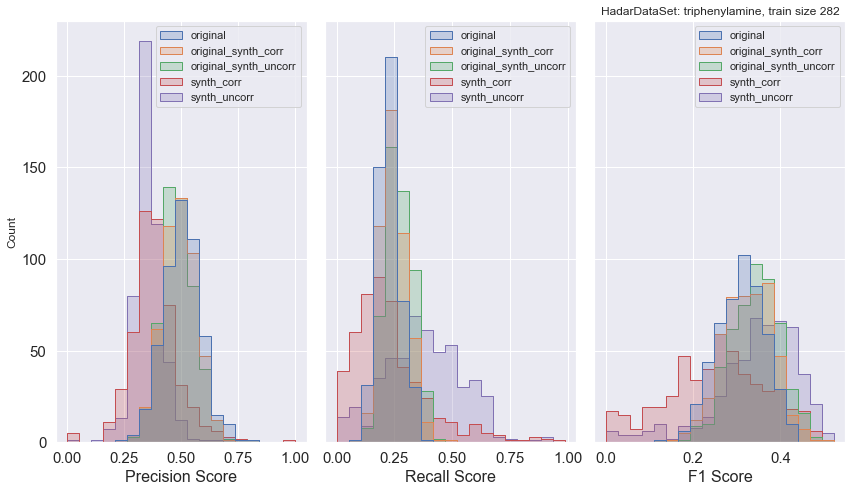

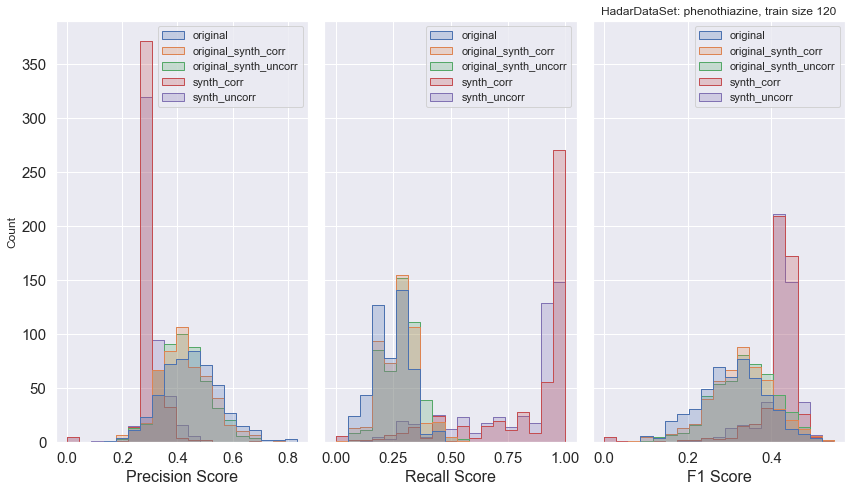

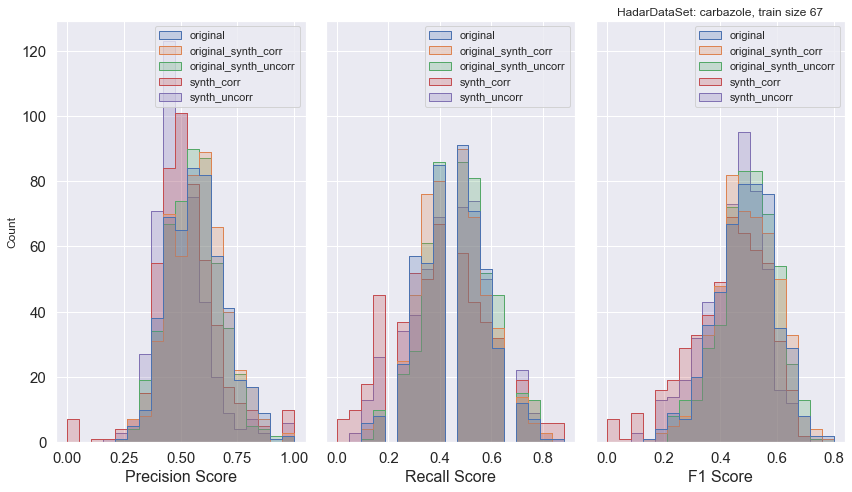

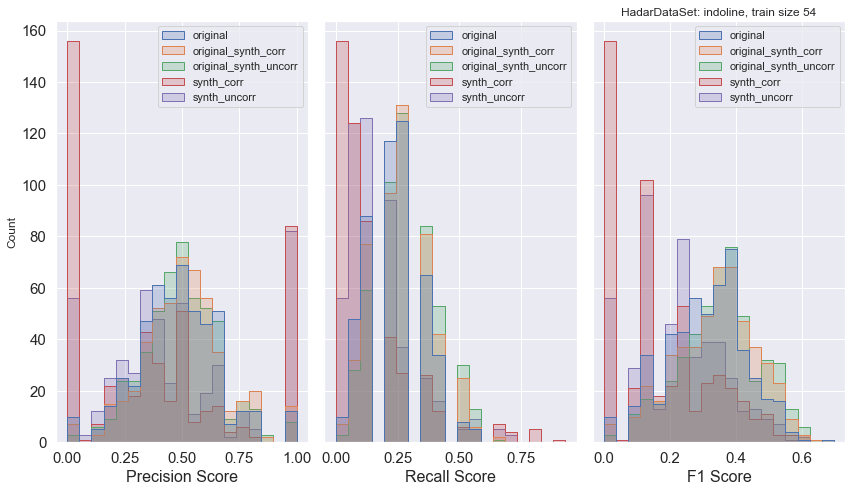

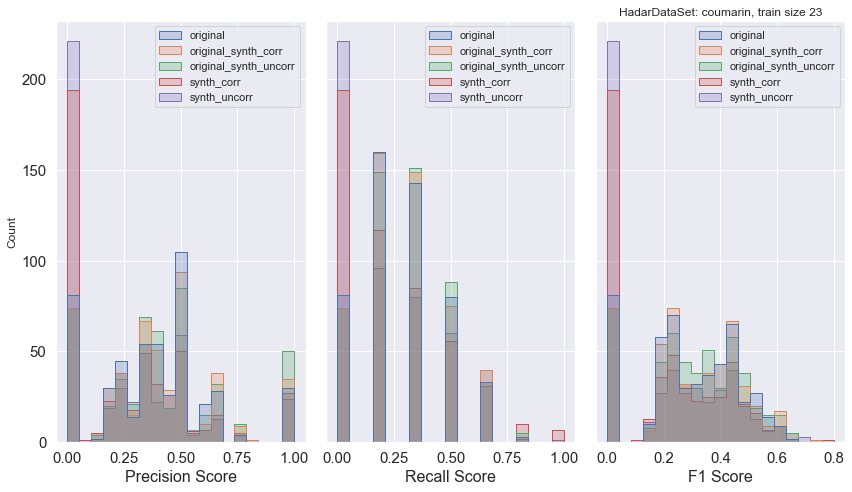

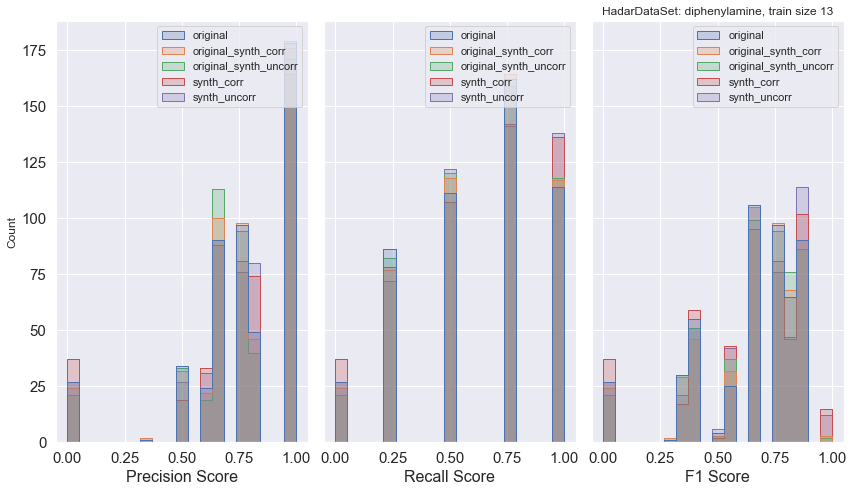

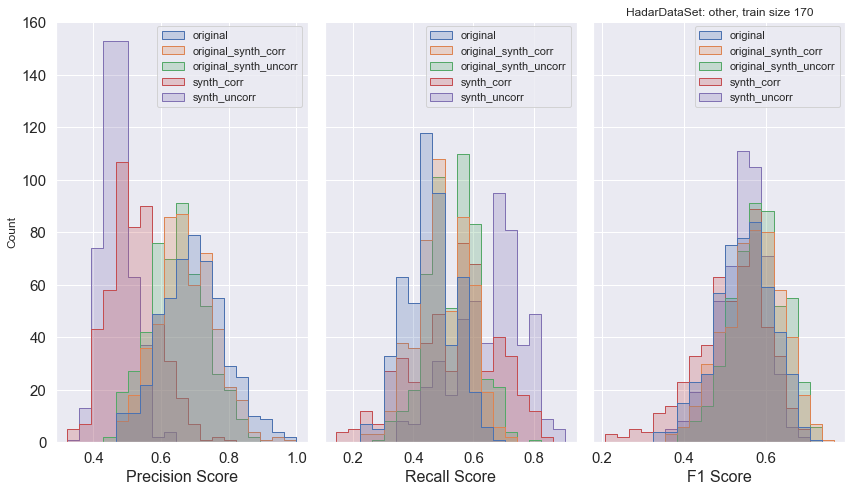

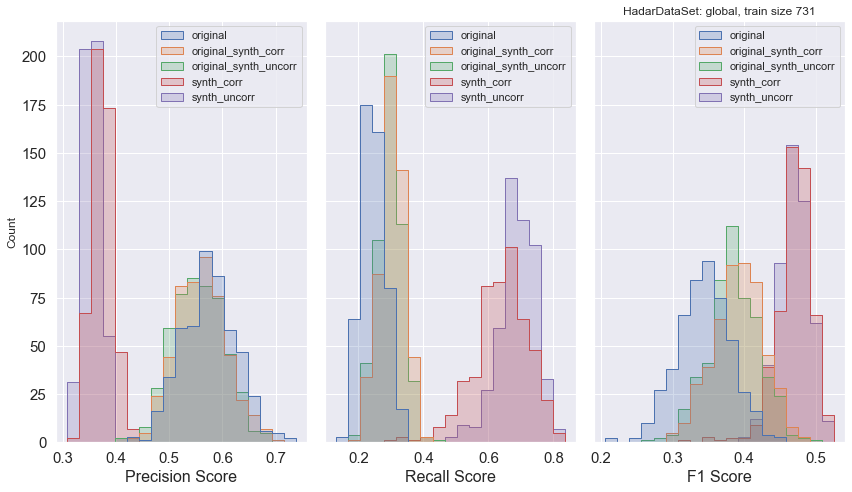

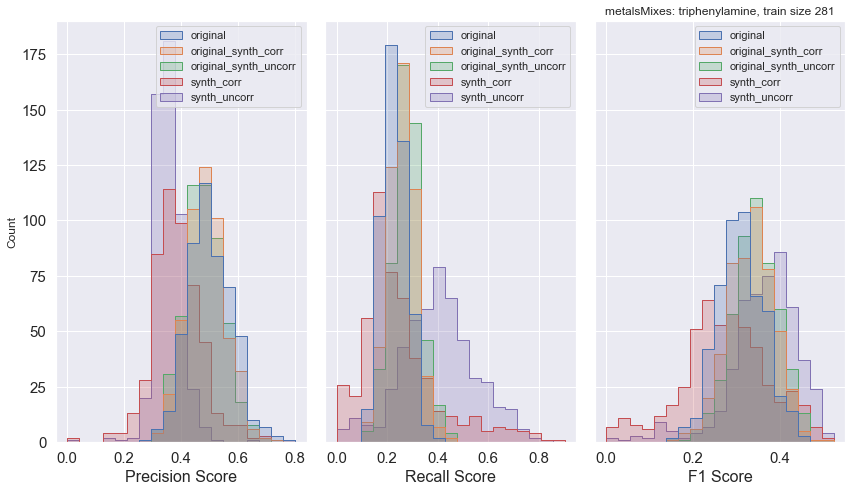

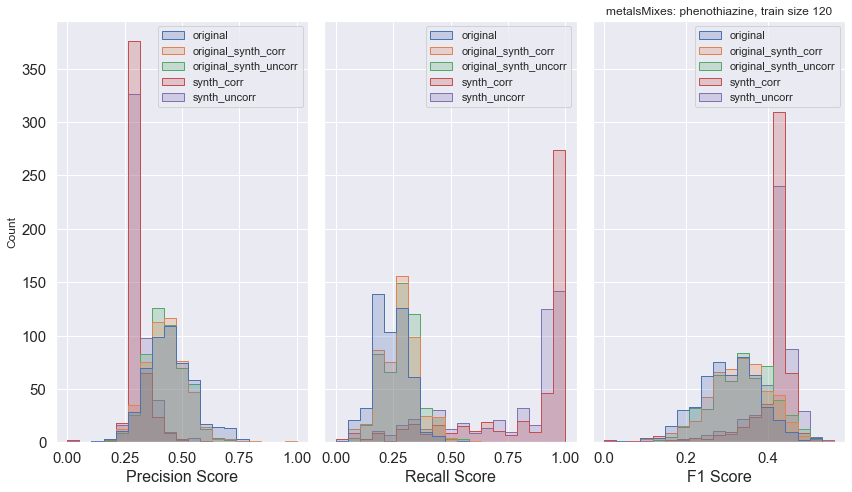

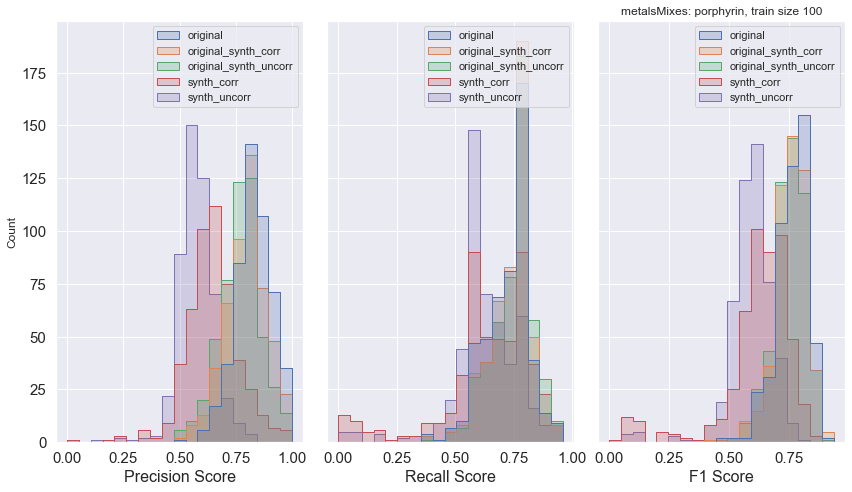

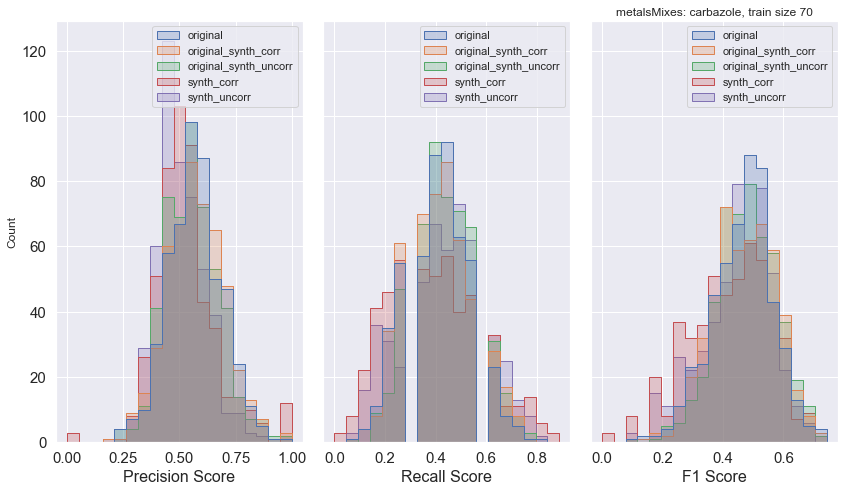

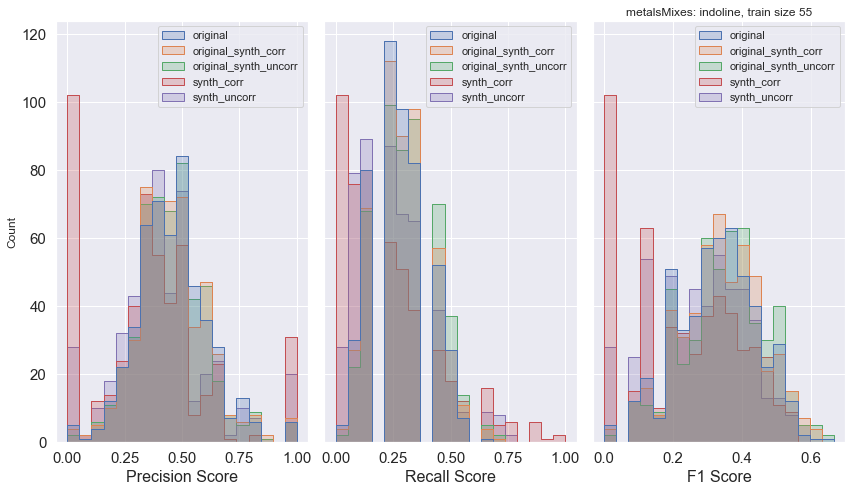

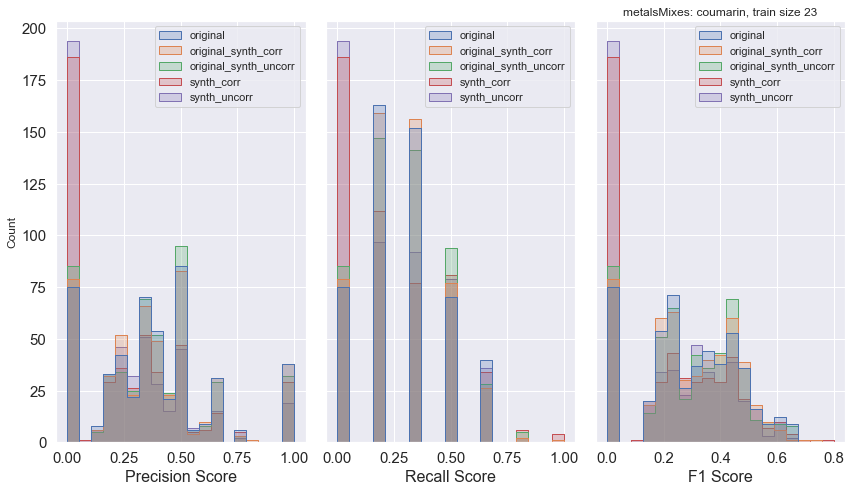

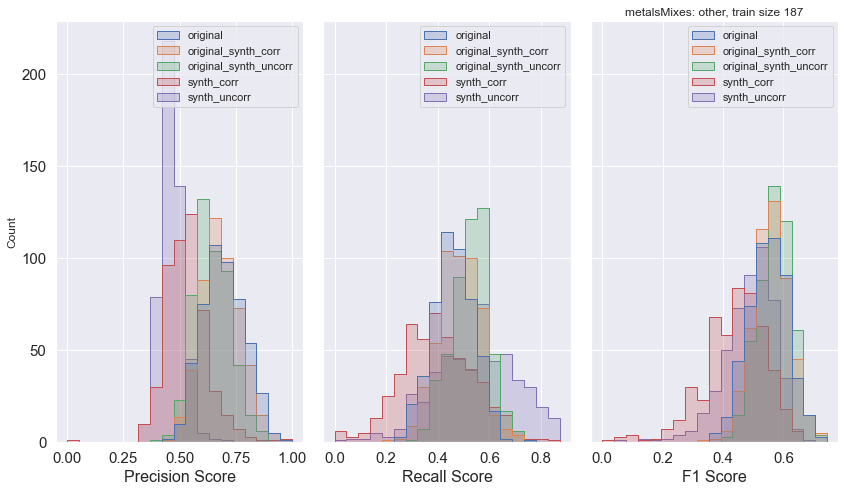

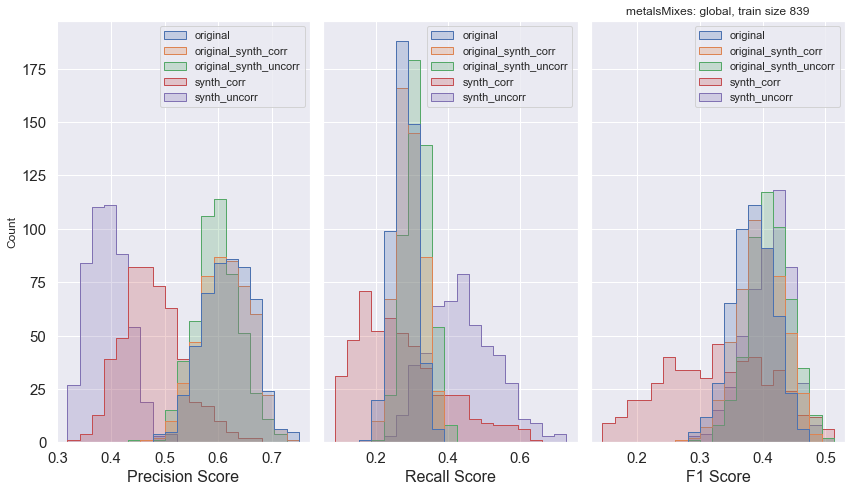

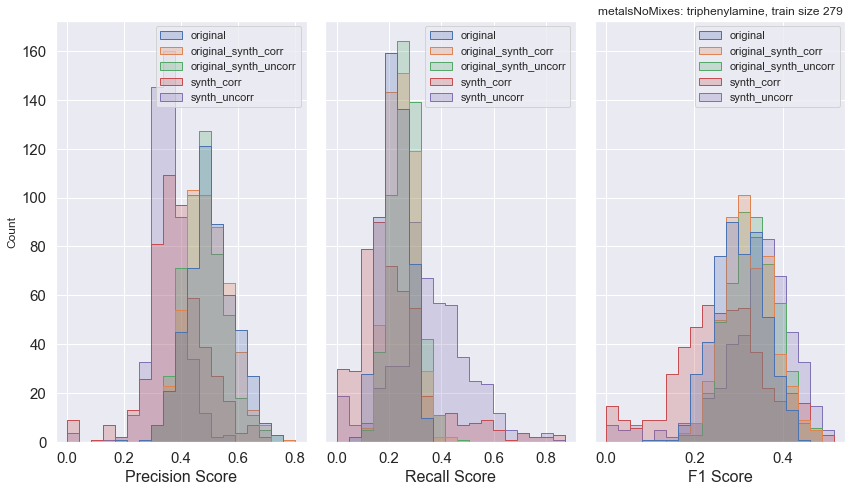

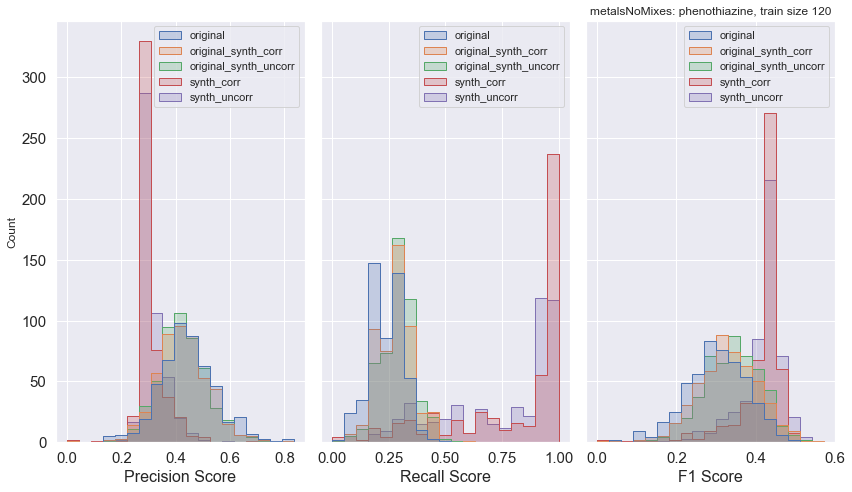

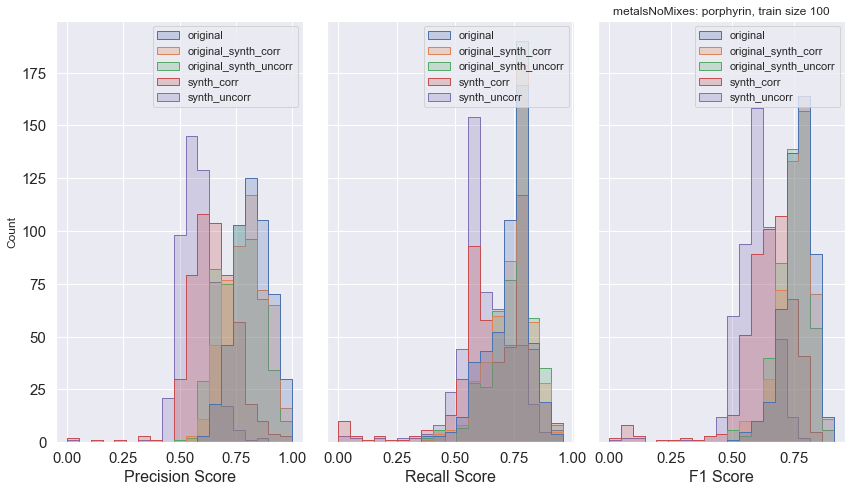

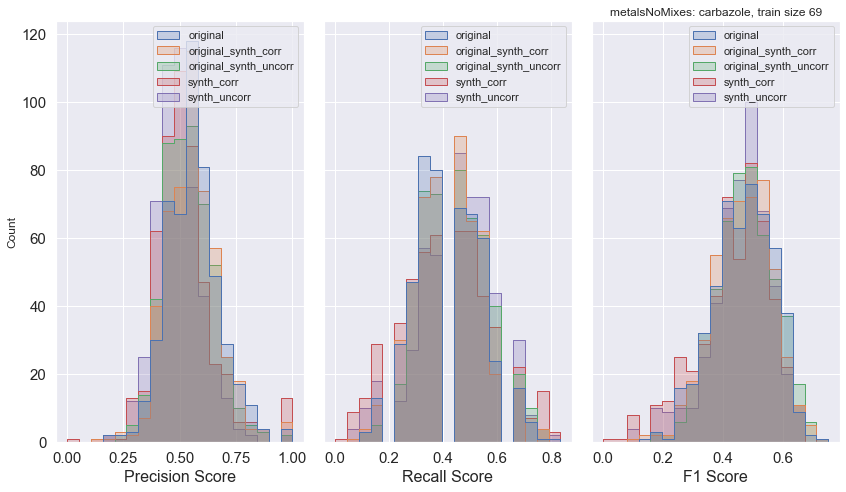

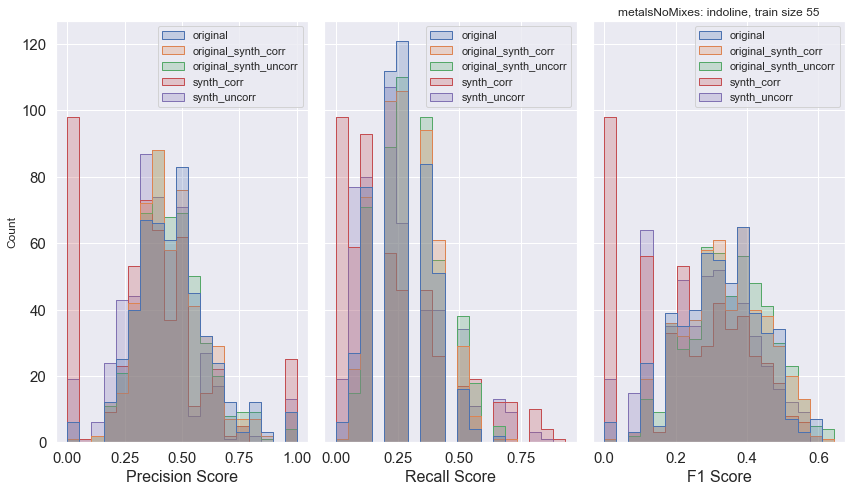

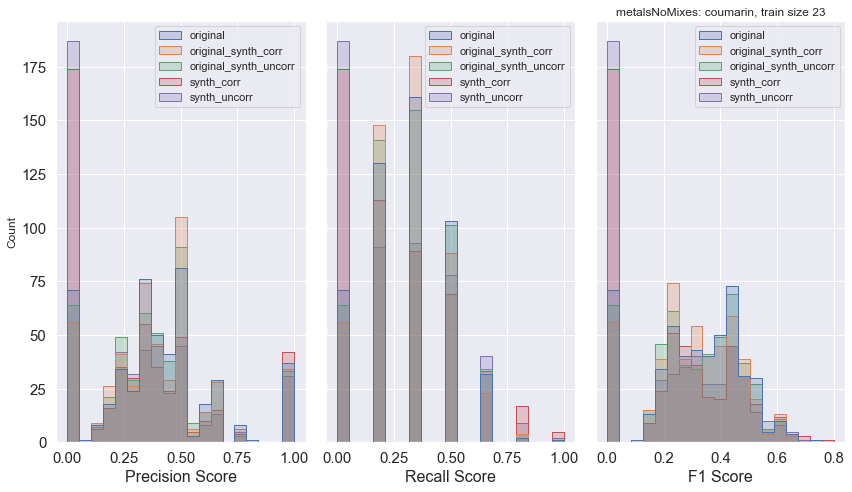

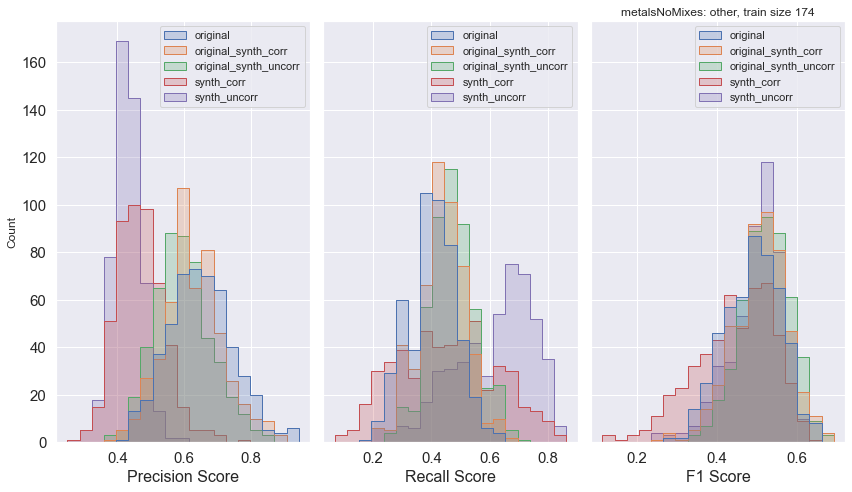

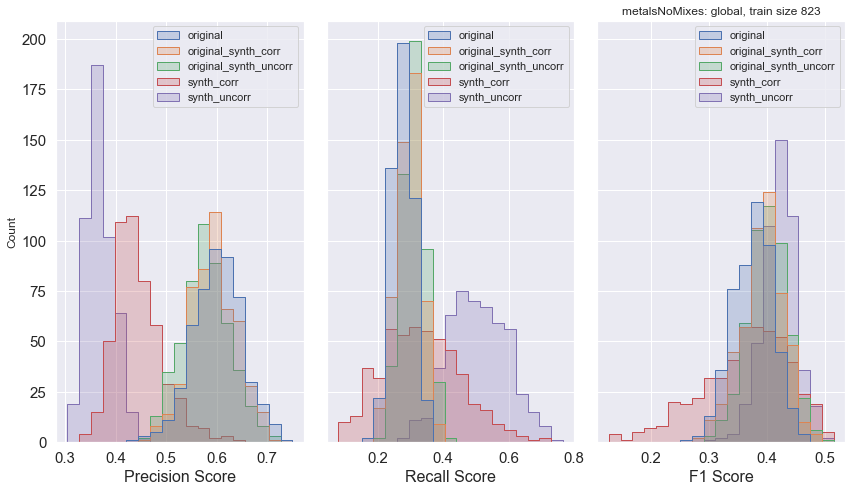

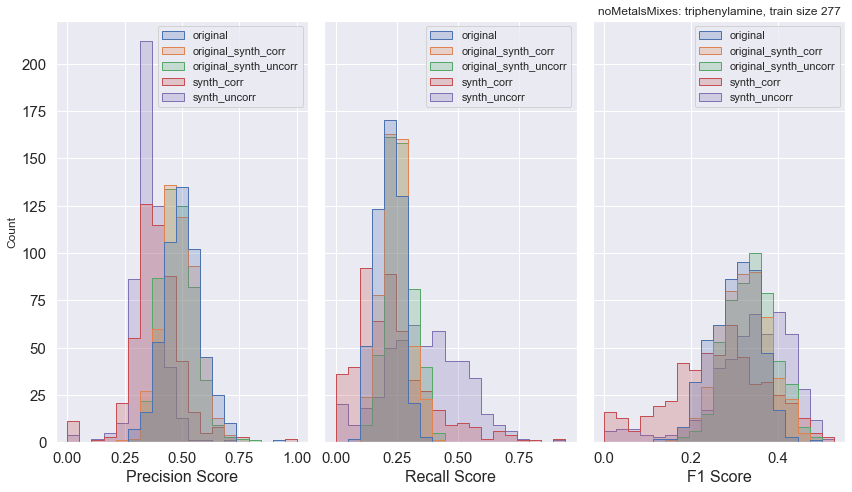

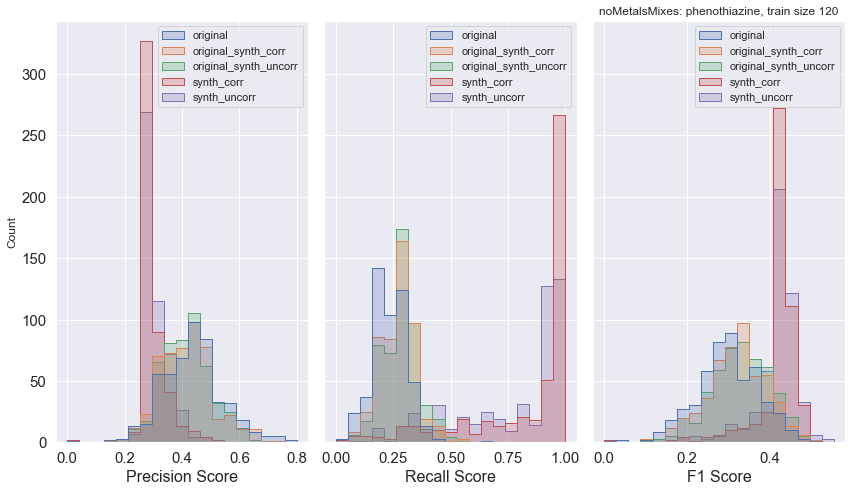

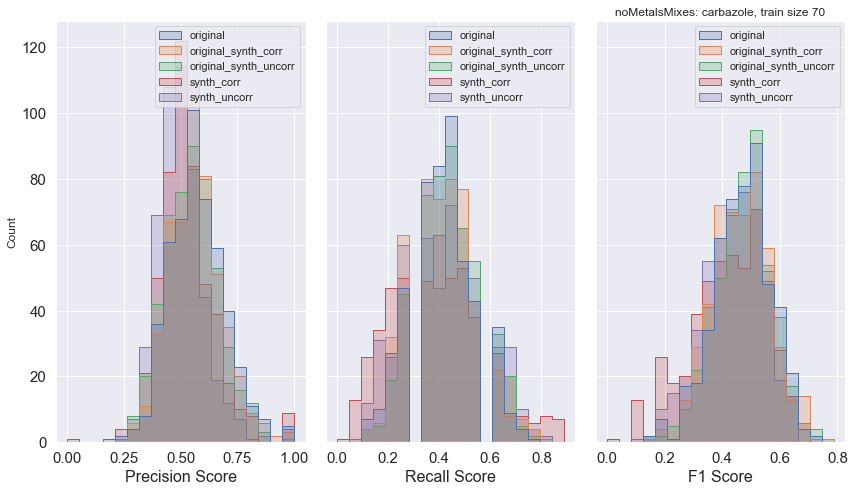

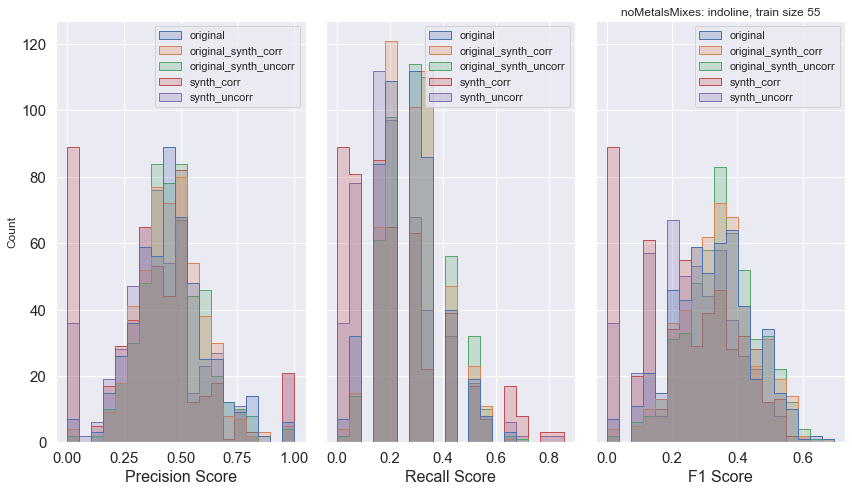

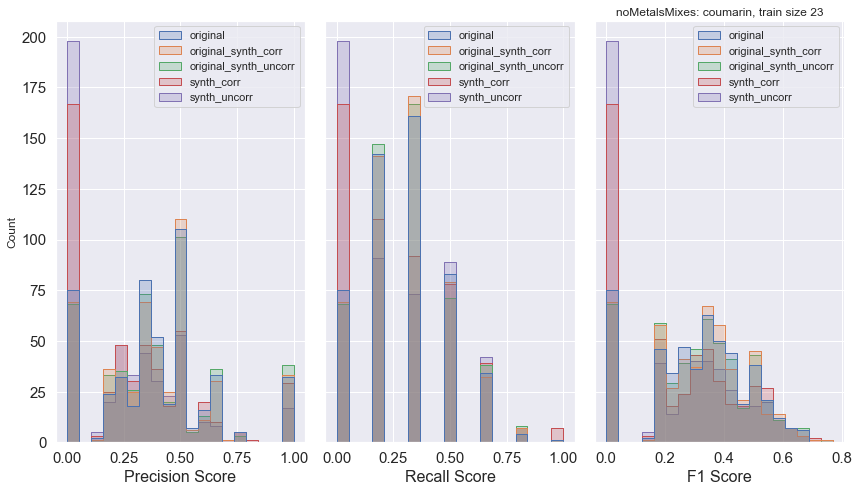

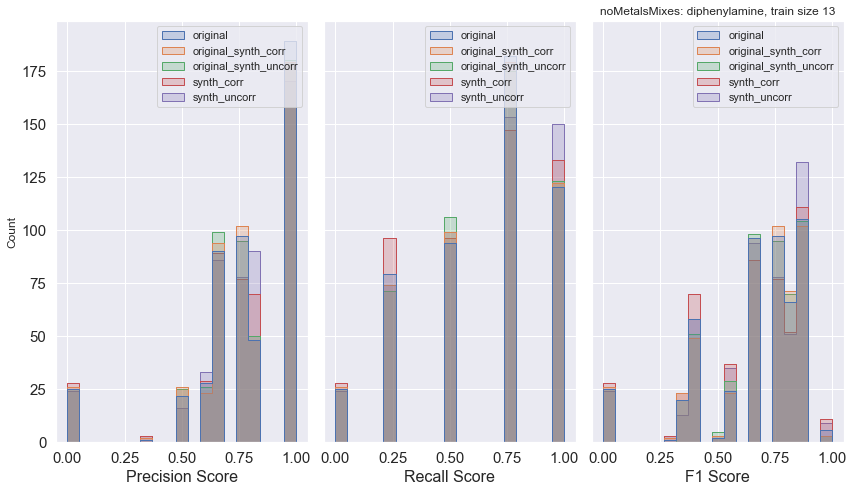

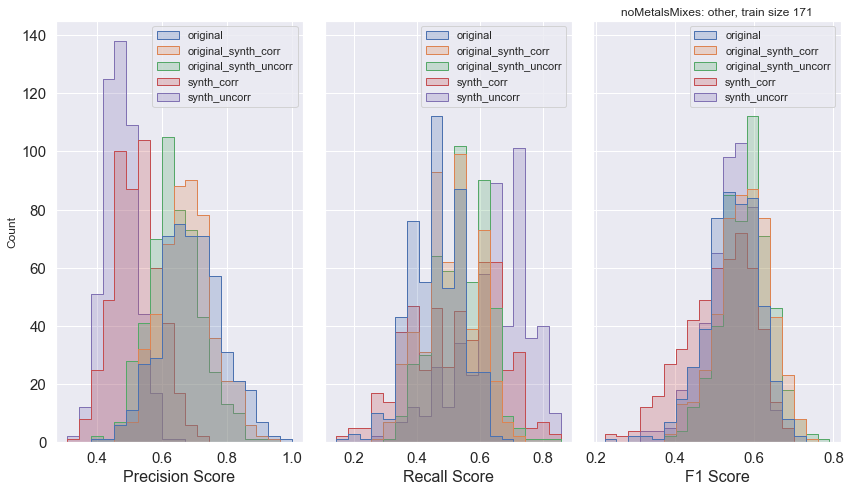

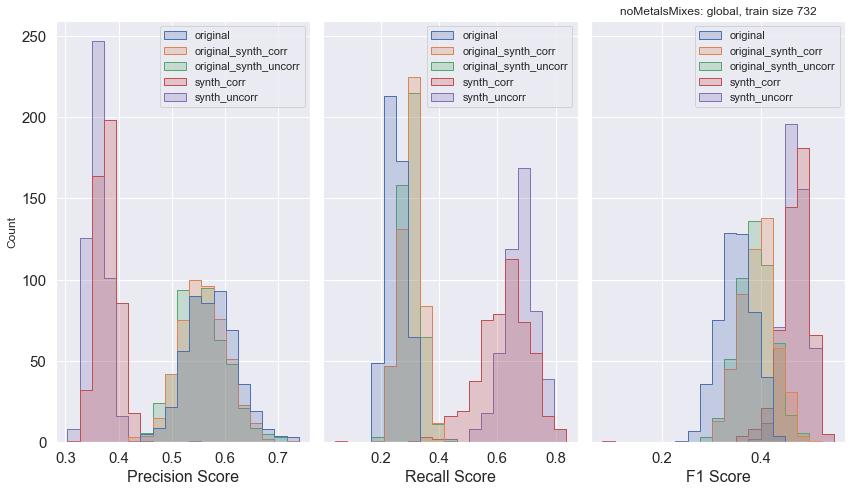

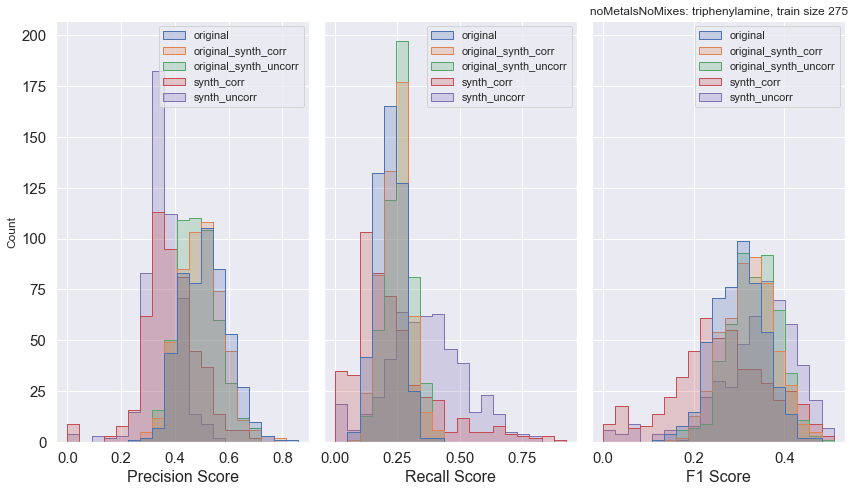

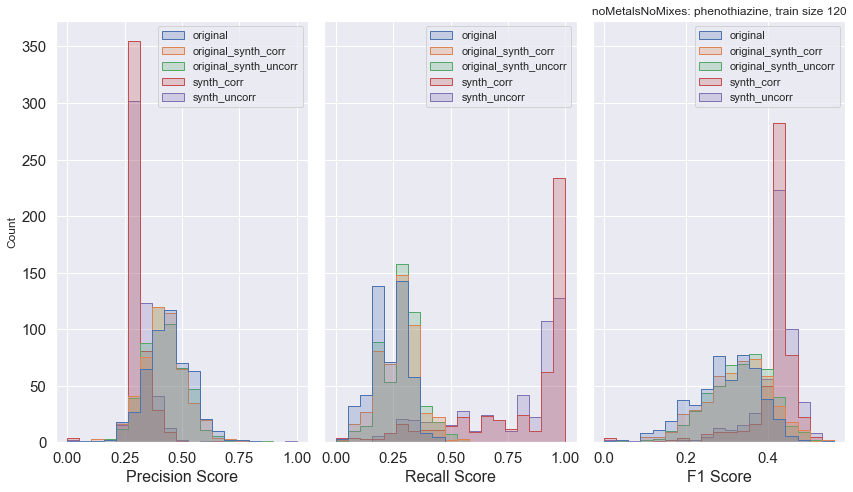

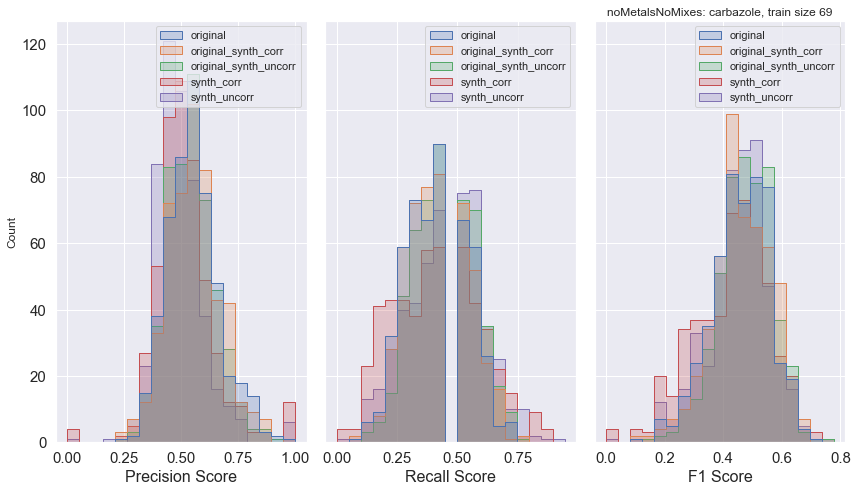

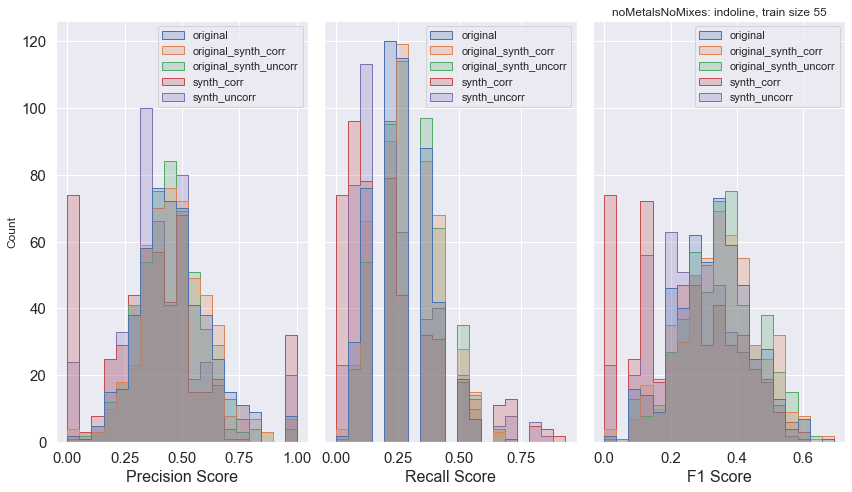

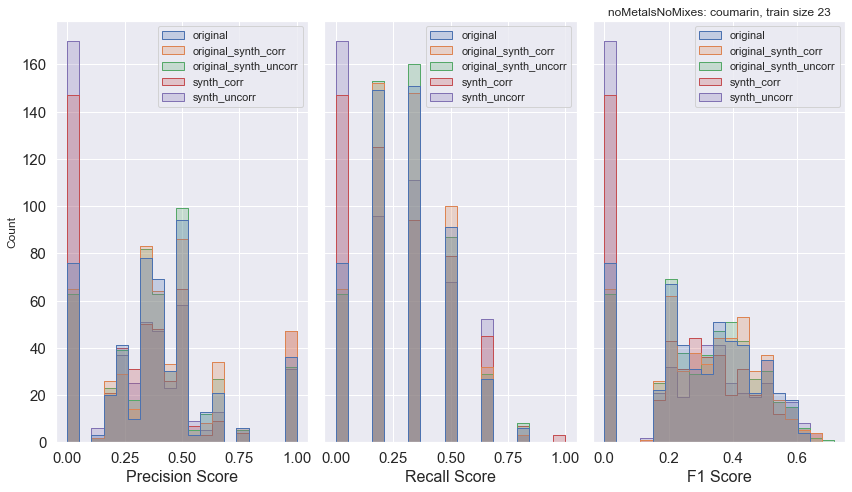

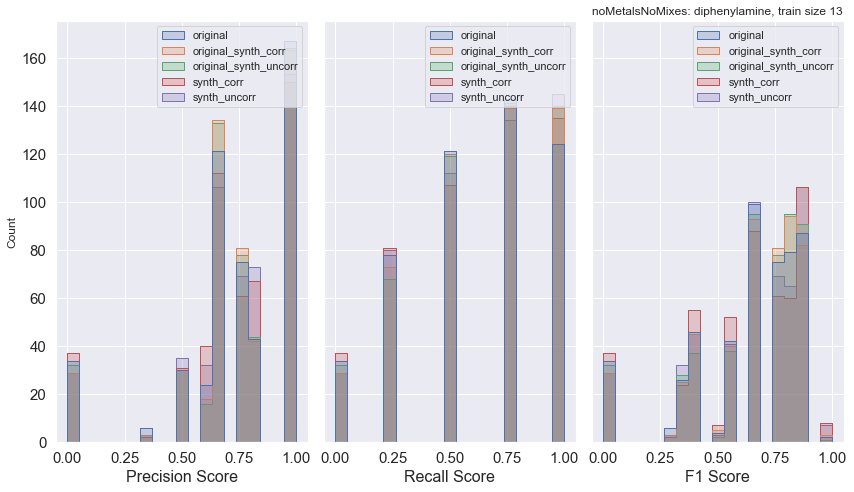

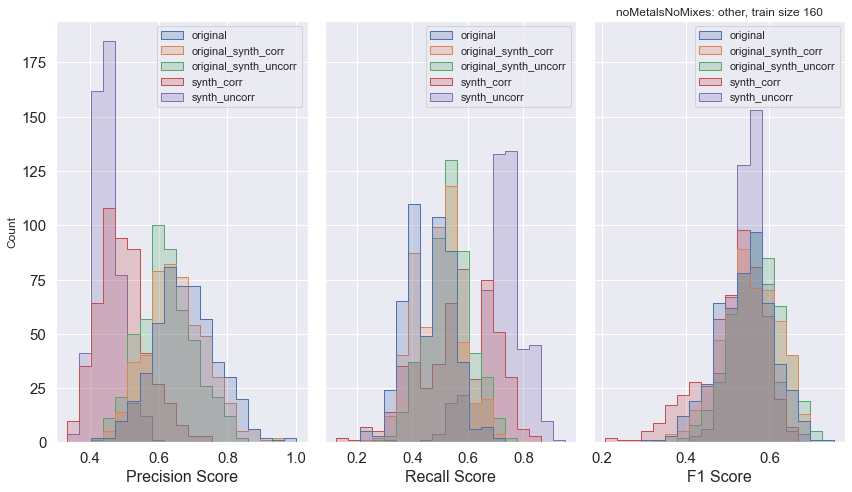

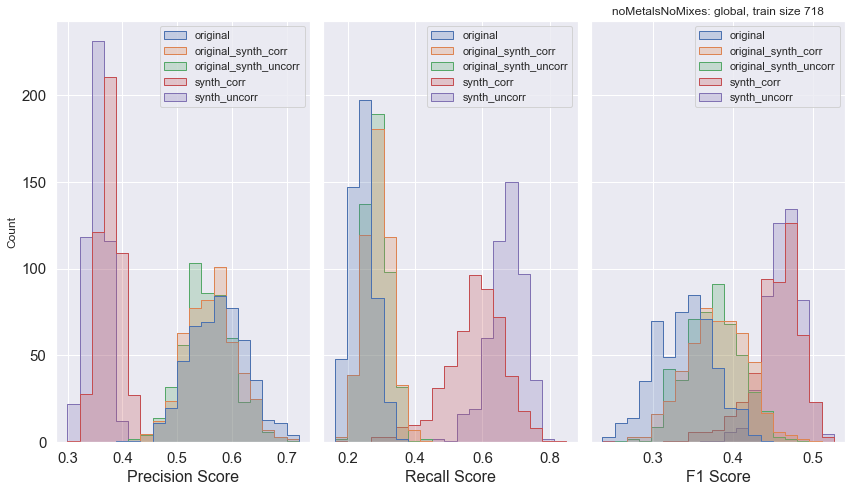

In [22]:
dssc_multimodel(X_all)

In [234]:
Y_families['triphenylamine']

,SMILES,Electrolyte,Semiconductor,Solar simulator,Article DOI,Molecule spectrum absorption maxima,Molecule spectrum emission maxima,VOC,JSC,FF,PCE,active
366,N#C/C(=C/c1cn(c2c1cccc2)c1ccc(cc1)N(c1ccccc1)c...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.synthmet.2015.10.024,375.0,NaN,680.0,4.39,0.710,2.15,0
430,CCCCCCOc1cc(OCCCCCC)ccc1c1ccc(cc1)N(c1ccc(cc1)...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1021/am403210v,628.0,NaN,560.0,12.60,0.723,5.10,0
471,CCCCCCC(Cc1cc(sc1c1cc2c(s1)c1sc(cc1c1c2non1)c1...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1021/am5067145,462.0,658.0,700.0,12.60,0.710,6.18,1
488,N#C/C(=C\c1sc(c2c1OCC(CO2)(C)C)c1sc(c2c1OCC(CO...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1021/ol902973r,499.0,NaN,756.0,9.54,0.620,4.45,0
512,CCCCCCSc1ccc(cc1)N(c1ccc(cc1)SCCCCCC)c1ccc(cc1...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1039/c5ra03530a,510.0,573.0,716.0,16.20,0.630,7.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1458,N#CC(=Cc1ccc(s1)c1nc(c(s1)c1ccc(cc1)N(c1ccc(cc...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.dyepig.2012.02.014,505.0,640.0,558.0,1.42,0.510,0.41,0
1459,N#CC(=Cc1ccc(s1)c1nc(c(s1)c1ccc(cc1)N(c1ccc(cc...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1016/j.dyepig.2012.02.014,503.0,611.0,519.0,1.81,0.460,0.44,0
1460,N#C/C(=C\c1ccc(n1CCCCCCOc1ccc(cc1)C(=O)OC)/C=C...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1021/am403668d,488.0,NaN,720.0,12.61,0.650,5.94,1
1461,N#C/C(=C\c1ccc(n1CCCCCCOc1ccc(cc1)C(=O)OC(C)(C...,Iodide_Triiodide,TiO2,AM 1.5G 100mW/cm2,10.1021/am403668d,486.0,NaN,700.0,12.60,0.670,5.88,1


In [144]:
train_test_sets_global = multi_train_test_split(X_raw, Y_dict)

In [238]:
train_test_sets_families = multi_train_test_split(X_families, Y_families)

In [196]:
train_test_sets_families['triphenylamine']['Y_test']

603     0
1001    0
1221    0
769     1
964     0
       ..
811     0
579     0
1447    0
668     0
714     0
Name: active, Length: 282, dtype: int32

<h2>Global Model Without RFE or Model Optimisation</h2>

In [186]:
def blunt_model(input_train_test_sets):
    for dataset in input_train_test_sets:
        X_train = input_train_test_sets[dataset]['X_train']
        Y_train = input_train_test_sets[dataset]['Y_train']
        X_test = input_train_test_sets[dataset]['X_test']
        Y_test = input_train_test_sets[dataset]['Y_test']
        
        model = RandomForestClassifier(n_estimators = 1000)
        model.fit(X_train, Y_train)
        
        predict_test = model.predict(X_test)
#         r2_test = r2_score(Y_test, predict_test)
        
        results = results_df(Y_test, predict_test, X_test)
        
        print(f"Dataset: {dataset}\n{classification_report(Y_test, predict_test)}")
        
        
#         plt.figure(figsize=(9,9))
#         sns.scatterplot(data=results, x='True', y='Predicted'#, hue = 'Compound Family'
#                        )
# #         
# #         plt.scatter(Y_test, predict_test, c='crimson')
        
# #         p1 = max(max(predict_test), max(Y_test))
# #         p2 = min(min(predict_test), min(Y_test))
# #         plt.plot([p1, p2], [p1, p2], 'b-')
# #         plt.xlabel('True Values', fontsize=15)
# #         plt.ylabel('Predictions', fontsize=15)
# #         plt.axis('equal')
#         plt.xlim(0, 10)
#         plt.ylim(0,10)
#         plt.title(f"Dataset: {dataset} Correlation: {round(r2_test, 2)}")
#         plt.show()
        

In [126]:
def global_transferL_model(family_train_test):
    global_X_train_df = pd.DataFrame(columns=family_train_test['triphenylamine']['X_train'].columns)
    global_Y_train_df = pd.DataFrame()
    for dataset in family_train_test:
        global_X_train_df = pd.concat([global_X_train_df, family_train_test[dataset]['X_train']], axis=0)
        global_Y_train_df = pd.concat([global_Y_train_df, family_train_test[dataset]['Y_train']], axis=0)
    
    
    model = RandomForestRegressor(n_estimators = 1000, max_features='sqrt')
    
    model.fit(global_X_train_df, global_Y_train_df)
    
    for dataset in family_train_test:
        X_test = family_train_test[dataset]['X_test']
        Y_test = family_train_test[dataset]['Y_test']
        predict_test = model.predict(X_test)
        r2_test = r2_score(Y_test, predict_test)
        results = results_df(Y_test, predict_test, X_test)
        
        plt.figure(figsize=(9,9))
        sns.scatterplot(data=results, x='True', y='Predicted')
        plt.xlim(0, 10)
        plt.ylim(0,10)
        plt.title(f"Dataset: {dataset} Correlation: {round(r2_test, 2)}")
        plt.show()
        

In [55]:
def results_df(Y_test, predict_test, X_test):
    data = dict()
    data['True'] = Y_test
    data['Predicted'] = predict_test
#     data['Compound Family'] = X_test['Molecule keywords'].astype(str)
    df = pd.DataFrame(data)
    return df
    

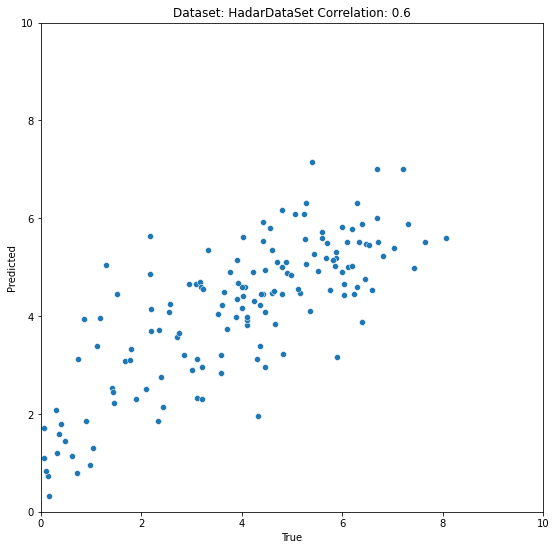

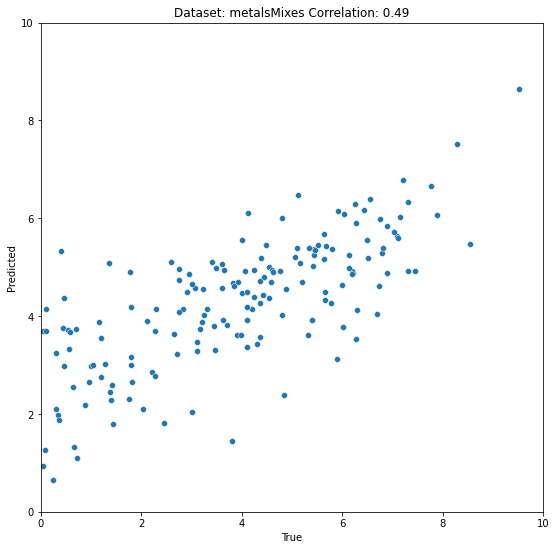

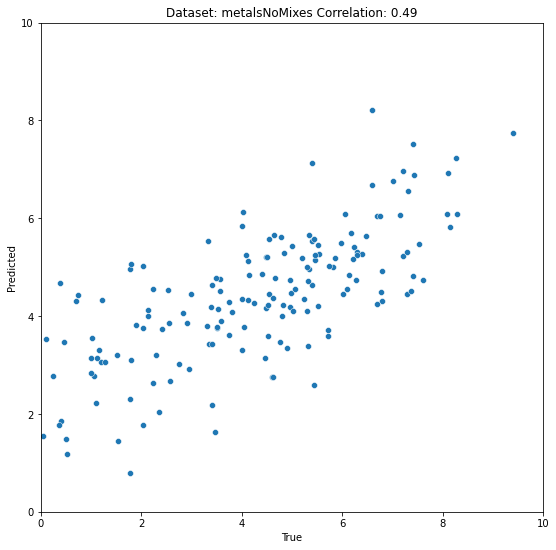

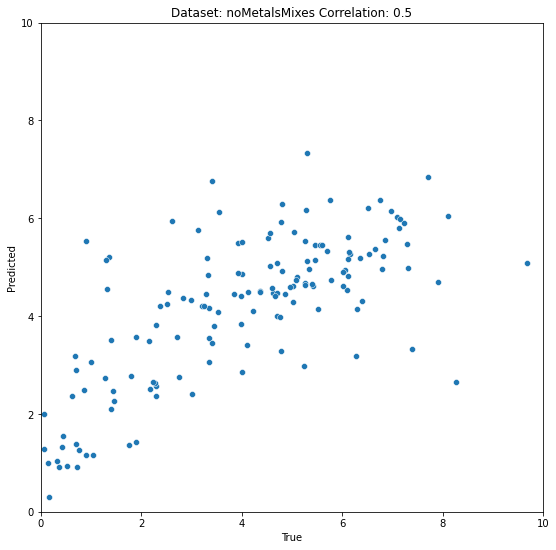

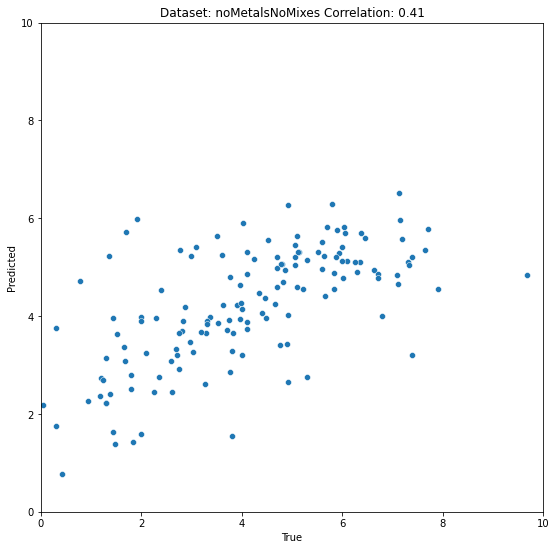

In [145]:
blunt_model(train_test_sets_global)

In [239]:
blunt_model(train_test_sets_families)

Dataset: triphenylamine
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       207
           1       0.68      0.31      0.43        74

    accuracy                           0.78       281
   macro avg       0.73      0.63      0.64       281
weighted avg       0.76      0.78      0.75       281

Dataset: other
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       150
           1       0.83      0.53      0.65        38

    accuracy                           0.88       188
   macro avg       0.86      0.75      0.79       188
weighted avg       0.88      0.88      0.87       188

Dataset: phenothiazine
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        86
           1       0.33      0.17      0.23        35

    accuracy                           0.66       121
   macro avg       0.53      0.52      0.50       121
weighted avg

C:\Users\clarkep\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\clarkep\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\clarkep\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h2>RFE</h2>

In [146]:
def multi_rfeCV(input_train_test_sets):
    for dataset in input_train_test_sets:
        X_train = input_train_test_sets[dataset]['X_train']
        Y_train = input_train_test_sets[dataset]['Y_train']
        
        model = RandomForestRegressor()
        
        rfeCV = RFECV(
            estimator=model,
            step=200,
            cv=2,
            scoring='r2',
            min_features_to_select=1
        )
        
        rfeCV.fit(X_train, Y_train)
        
        plt.figure()
        plt.plot(
                 rfeCV.grid_scores_
                )
        plt.xlabel("Proportion of data (n/6)")
        plt.ylabel("Cross validation score (r2)")
        plt.title(f"Datase: {dataset}, Best n_features: {rfeCV.n_features_}/{len(X_train.columns)}")
        plt.show()

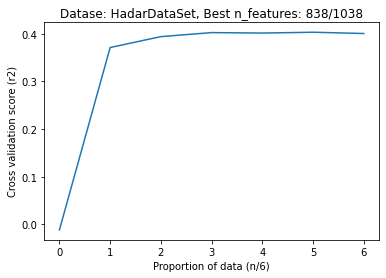

KeyboardInterrupt: 

In [191]:
multi_rfeCV(train_test_sets_global)

In [109]:
def multi_rfe(input_train_test_sets):
    new_dict = dict()
    for dataset in input_train_test_sets:
        train_test = dict()
        n_features = round(len(input_train_test_sets[dataset]['X_train'].columns)/3)
        X_train = input_train_test_sets[dataset]['X_train']
        Y_train = input_train_test_sets[dataset]['Y_train']
        X_test = input_train_test_sets[dataset]['X_test']
        Y_test = input_train_test_sets[dataset]['Y_test']
        
        model = RandomForestRegressor(max_features='sqrt')
        
        rfe = RFE(estimator=model, n_features_to_select=n_features, step=1)
        
        rfe.fit(X_train, Y_train)
        
        train_test['X_train'] = X_train[X_train.columns[rfe.support_]]
        train_test['X_test'] = X_test[X_test.columns[rfe.support_]]
        train_test['Y_train'] = Y_train
        train_test['Y_test'] = Y_test
        
        new_dict[dataset] = train_test
        
    return new_dict

In [ ]:
trimmed_train_test = multi_rfe(train_test_sets)

In [98]:
trimmed_train_test_families = multi_rfe(train_test_sets_families)

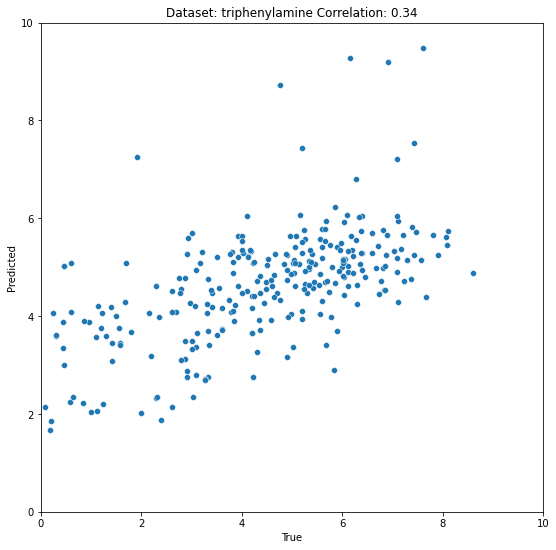

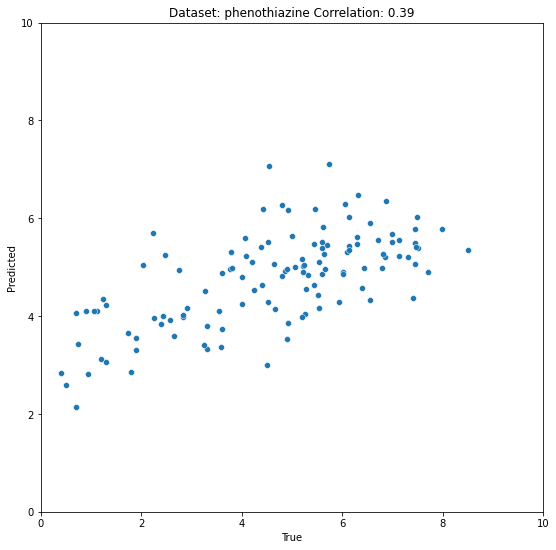

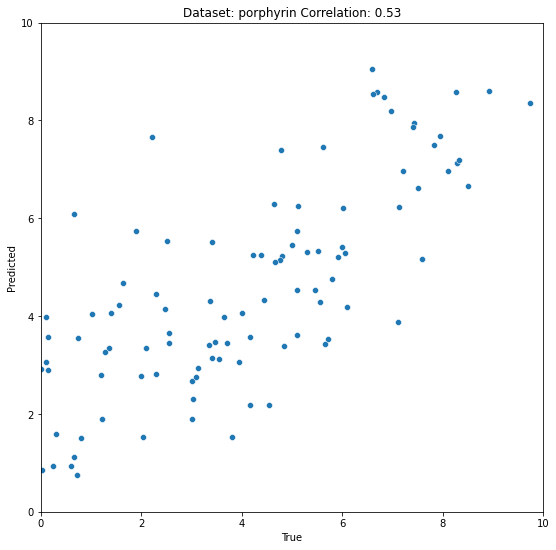

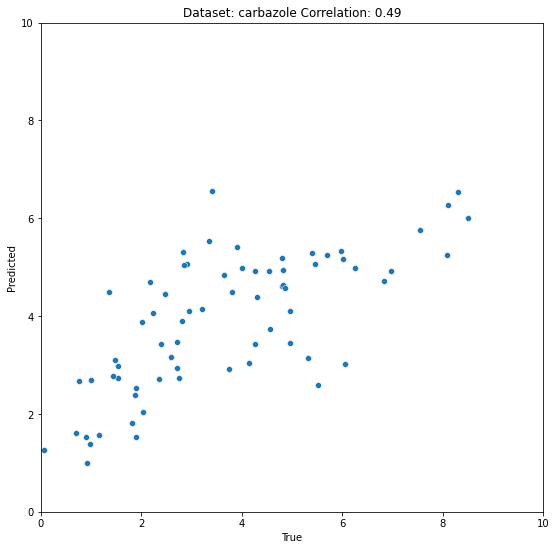

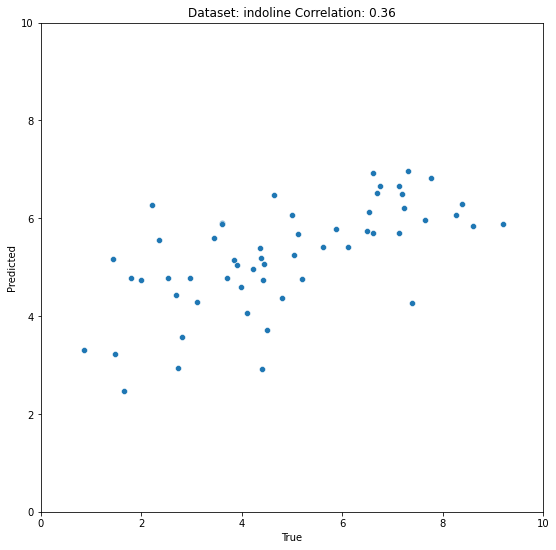

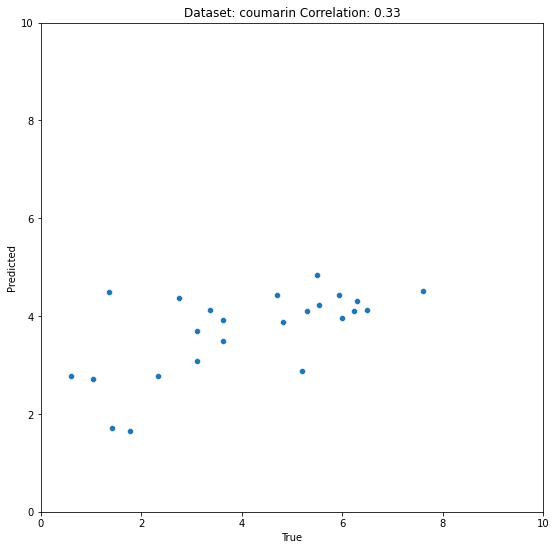

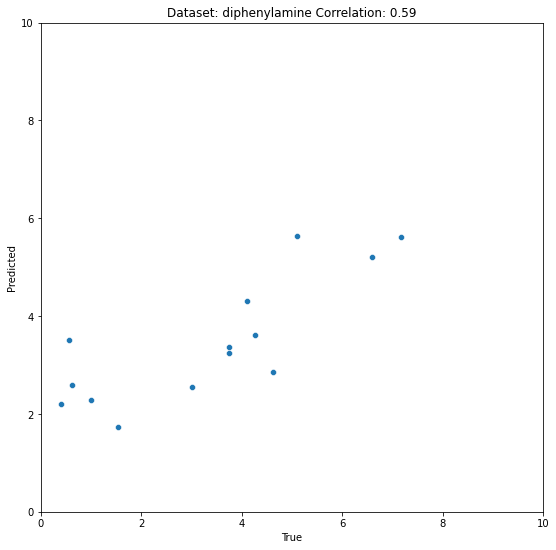

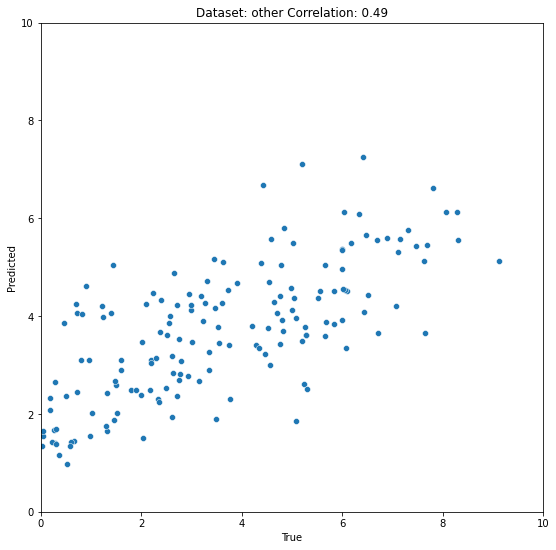

In [129]:
blunt_model(train_test_sets_families)

C:\Users\clarkep\AppData\Local\Temp/ipykernel_50120/3076897604.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(global_X_train_df, global_Y_train_df)


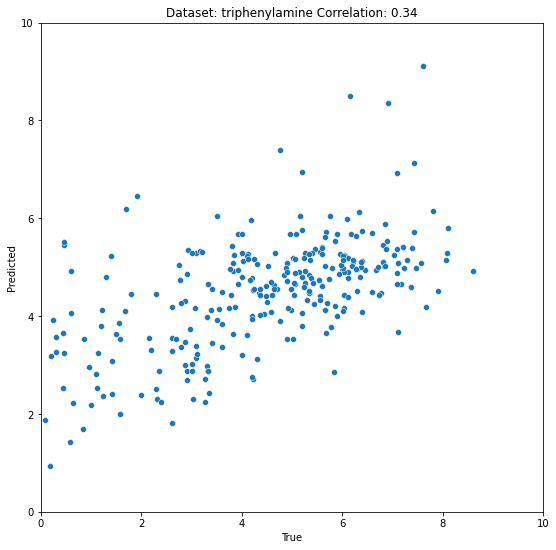

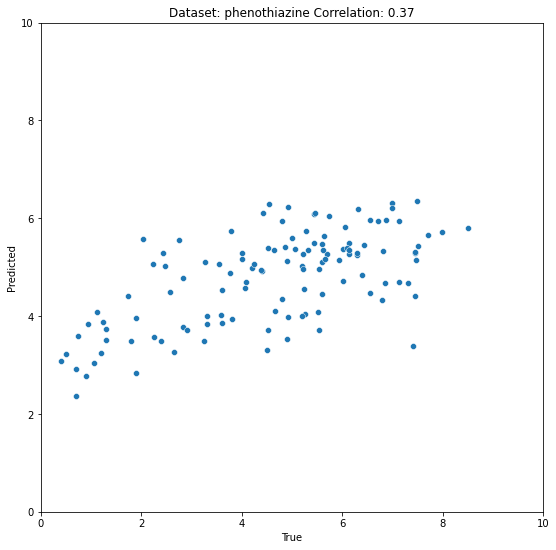

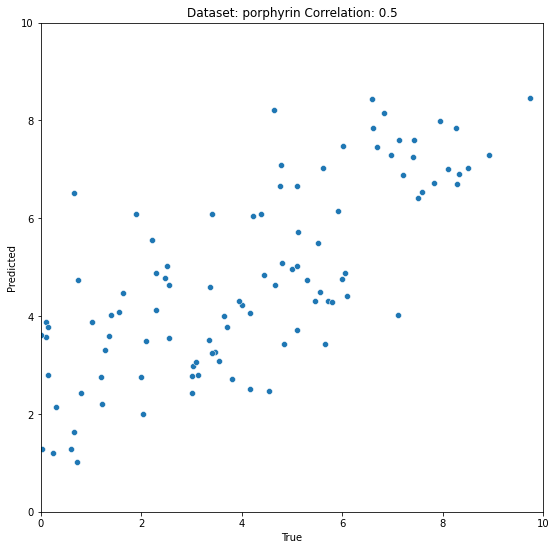

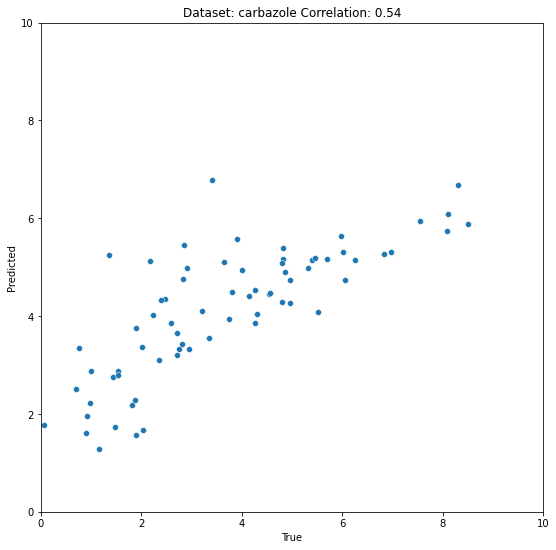

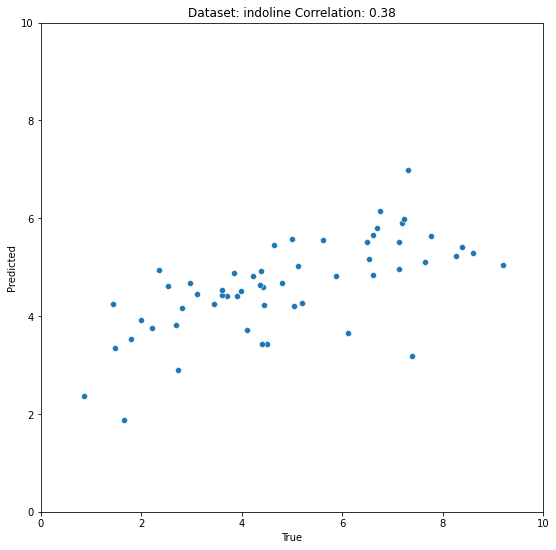

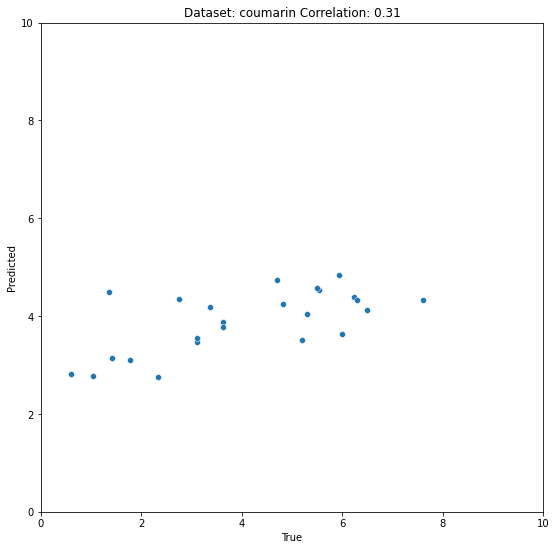

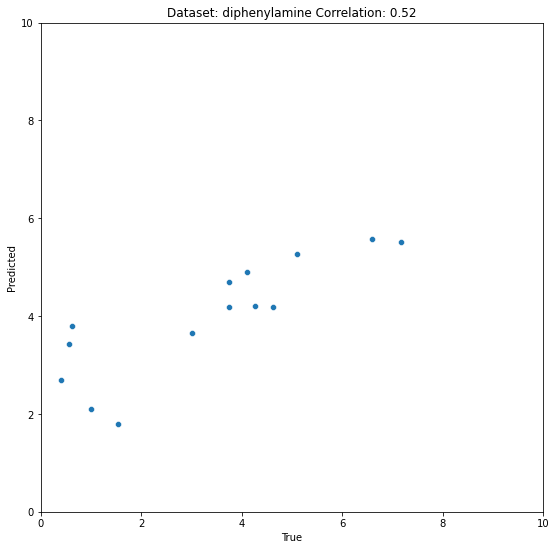

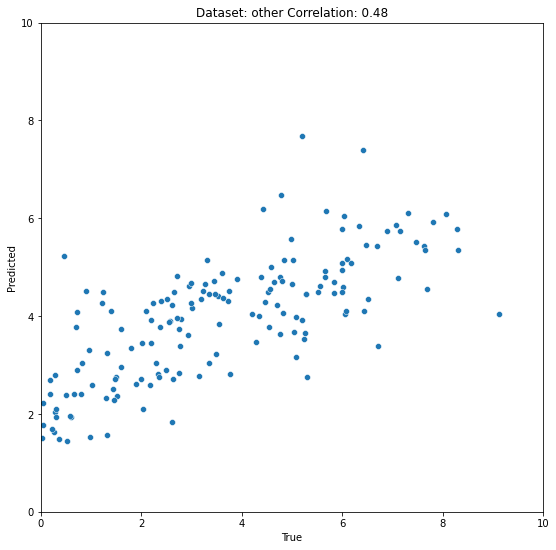

In [127]:
global_transferL_model(train_test_sets_families)